In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

Fri Feb 10 13:34:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   30C    P8     9W / 250W |    103MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import re
# import emoji
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

In [3]:
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
current_time

'2023_02_10-01_35PM'

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df1 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',lineterminator='\n',skipinitialspace=True,)
# df1['label']= 1
# df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1.shape

(4467, 5)

In [6]:
df1_pos = df1.loc[(df1['Substance'] != 'X') & (df1['Use'] != 'X') & (df1['Intent'] != 'X')]
df1_neg = df1.loc[(df1['Substance'] == 'X') & (df1['Use'] == 'X') & (df1['Intent'] == 'X')]

df1_pos.drop(df1_pos.columns[[0, 2,3,4]], axis=1, inplace=True)
df1_neg.drop(df1_neg.columns[[0, 2,3,4]], axis=1, inplace=True)
df1_pos['label']= 1
df1_neg['label']= 0
df1_neg.shape,  df1_pos.shape

/users/kent/jmaharja/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

((3605, 2), (456, 2))

In [7]:
# prediction result reviewed by Dr. King added for re-training
df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/ReviewedPrediction.csv',lineterminator='\n', skipinitialspace=True,)
df2.rename(columns = {'tweet':'Tweet'}, inplace = True)
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.shape

(821, 4)

In [8]:
df2_pos = df2.loc[(df2['type'] == 1) | (df2['use'] == 1) | (df2['intent'] ==1)]
df2_neg = df2.loc[(df2['type'] != 1) & (df2['use'] != 1) & (df2['intent'] !=1)]
df2_pos.drop(df2_pos.columns[[2,3,1]], axis=1, inplace=True)
df2_neg.drop(df2_neg.columns[[2,3,1]], axis=1, inplace=True)
df2_pos['label']= 1
df2_neg['label']= 0
df2_neg.shape,  df2_pos.shape

/users/kent/jmaharja/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

((641, 2), (180, 2))

In [9]:
# iteration (predicted result added for re-training)
df3 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/ReviewedPrediction_1.csv',lineterminator='\n', skipinitialspace=True,)
df3_pos= df3.loc[df3['label']==1]
df3_neg = df3.loc[df3['label']==0]
df3_neg.shape, df3_pos.shape

((386, 2), (587, 2))

In [10]:
# # predicted result from 202212 filtered by chatgpt added for retraining
# df4_pos =pd.read_csv('test_result/chatgpt/all_pos.csv',lineterminator='\n', skipinitialspace=True,)
# df4_neg =pd.read_csv('test_result/chatgpt/all_neg.csv',lineterminator='\n', skipinitialspace=True,)
# df4_pos.drop(df4_pos.columns[[0]], axis=1, inplace=True)
# df4_neg.drop(df4_neg.columns[[0]], axis=1, inplace=True)
# df4_pos['label']= 1
# df4_neg['label']= 0
# df4_neg.shape, df4_pos.shape

In [12]:
# df_pos = pd.concat([df1_pos, df2_pos, df3_pos, df4_pos])
# df_neg = pd.concat([df1_neg, df2_neg, df3_neg, df4_neg])
df_pos = pd.concat([df1_pos, df2_pos, df3_pos])
df_neg = pd.concat([df1_neg, df2_neg, df3_neg])
df_neg.shape,  df_pos.shape

((4632, 2), (1223, 2))

In [13]:
# foldername = '400Vs2000'
df1 = df_pos[:1150]
df2 = df_neg[:4550]
df = pd.concat([df1,df2])
df.shape

(5700, 2)

In [20]:
# df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
# df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
# df2['label'] = 0
# df4 = df2[1160000:]
# df2 = df2[:800]
# df4 = df4[:200]
# df2.shape, df4.shape

In [14]:
# df_test =pd.read_csv('/users/kent/jmaharja/drugAbuse/finetune/test_new.csv',
# #                    error_bad_lines=False,
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df_test.drop(df_test.columns[[1, 2, 3]], axis=1, inplace=True)
# # df_test.rename({'text': 'Tweet'}, axis=1, inplace=True)
# # df_test['label']=/ 1
# df_test = df_test.rename(columns={df_test.columns[1]: 'label'})
df_test_neg = df_neg[4550:]
df_test_pos = df_pos[1150:]
df3 = pd.concat([df_test_pos,df_test_neg])
df3.shape

(155, 2)

# DATA PREPROCESSING

In [13]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [15]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [16]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.data['Tweet'] = self.data['Tweet'].map(lambda x: self.cleaner(x))
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  
   def __len__(self):
    return len(self.data)

   def cleaner(self, tweet):
#         print(tweet)
        tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
        tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
        tweet = " ".join(tweet.split())
        #     tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
        #     tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
        #     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
        #          if w.lower() in words or not w.isalpha())
        return tweet
    
        
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_val = df_test
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((5130, 2), (570, 2), (155, 2))

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.5)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [20]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

In [21]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [22]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [24]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
best_accuracy = 0
val_acc = 0 

for epoch in range(EPOCHS):


#   modelPath = "checkpoint/best_ftc_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')
    best_accuracy = val_acc

**************************************** Training
2023_02_10-01_37PM
Epoch 1/16
----------
Train loss 0.3344479994993436 accuracy 0.8808966861598441
Val   loss 0.2461200864571664 accuracy 0.9157894736842106

Epoch 2/16
----------
Train loss 0.20057149260737164 accuracy 0.9421052631578947
Val   loss 0.2671023206009219 accuracy 0.9263157894736842

Epoch 3/16
----------
Train loss 0.1340491457449162 accuracy 0.9639376218323586
Val   loss 0.3180399372682182 accuracy 0.9245614035087719

Epoch 4/16
----------
Train loss 0.09836465817356825 accuracy 0.9775828460038986
Val   loss 0.31499374088727766 accuracy 0.9315789473684211

Epoch 5/16
----------
Train loss 0.06592952746628114 accuracy 0.9859649122807017
Val   loss 0.416128962983041 accuracy 0.9245614035087719

Epoch 6/16
----------
Train loss 0.04980604715135407 accuracy 0.9892787524366471
Val   loss 0.4248341402772995 accuracy 0.9263157894736842

Epoch 7/16
----------
Train loss 0.03869830721966064 accuracy 0.991812865497076
Val   loss 0.

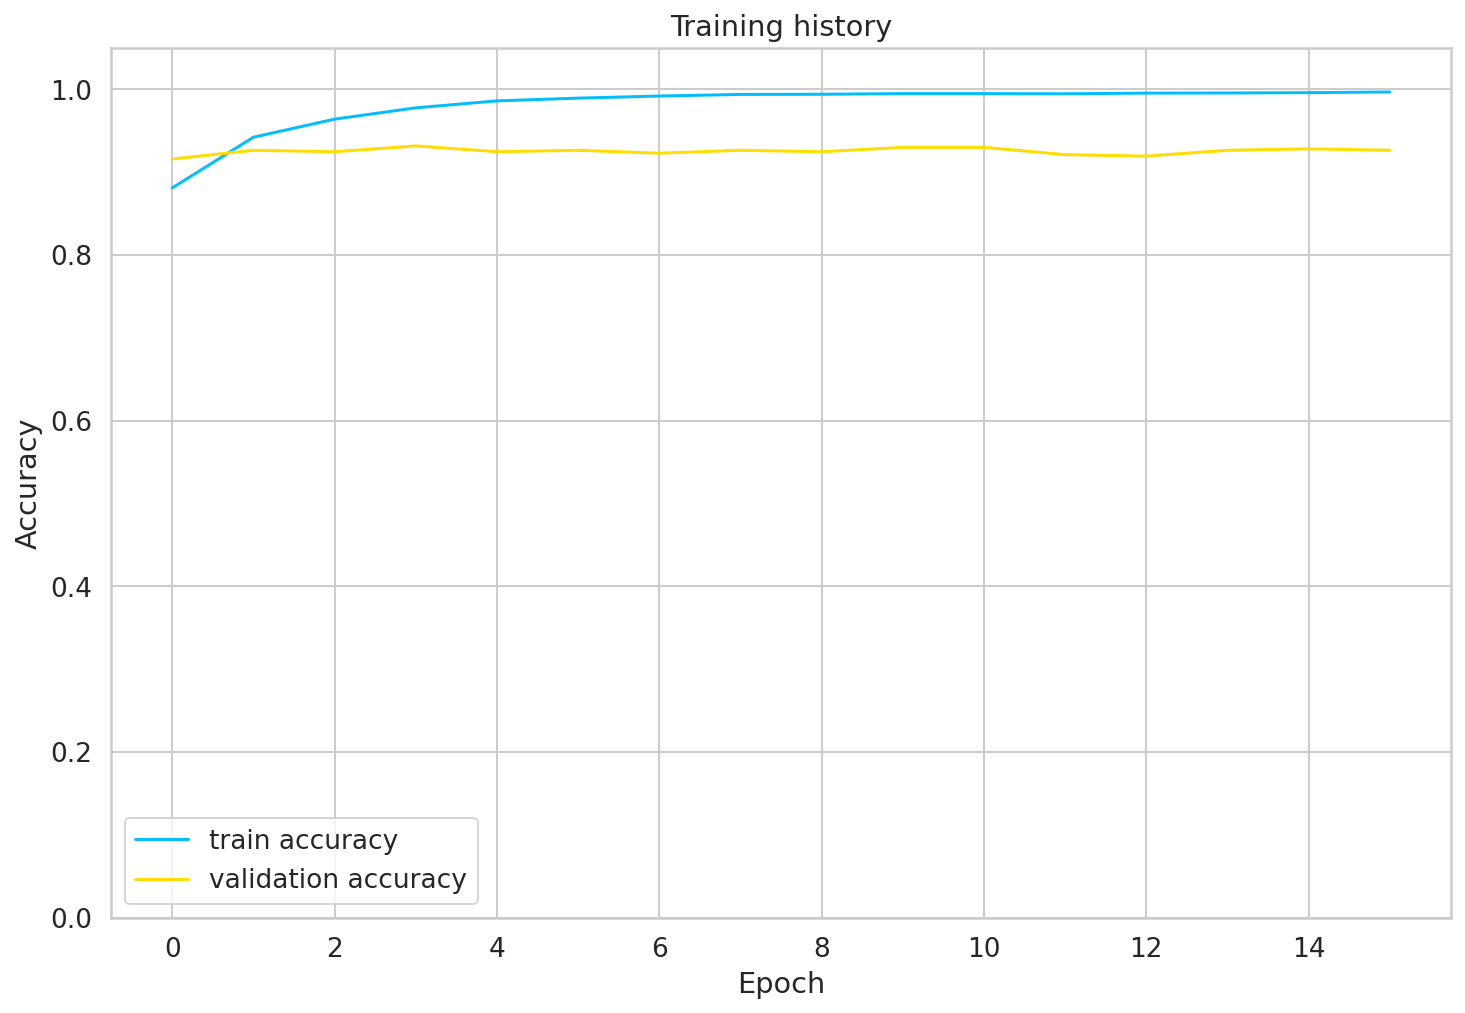

In [25]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig('images/training_history '+current_time+'.png')

In [26]:
torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')

In [27]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.8838709677419355

# PREDICTION


In [27]:
# model.load_state_dict(torch.load('checkpoint/best_ftc_model_state2023_01_17-02_22PM.bin'))

In [28]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [29]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

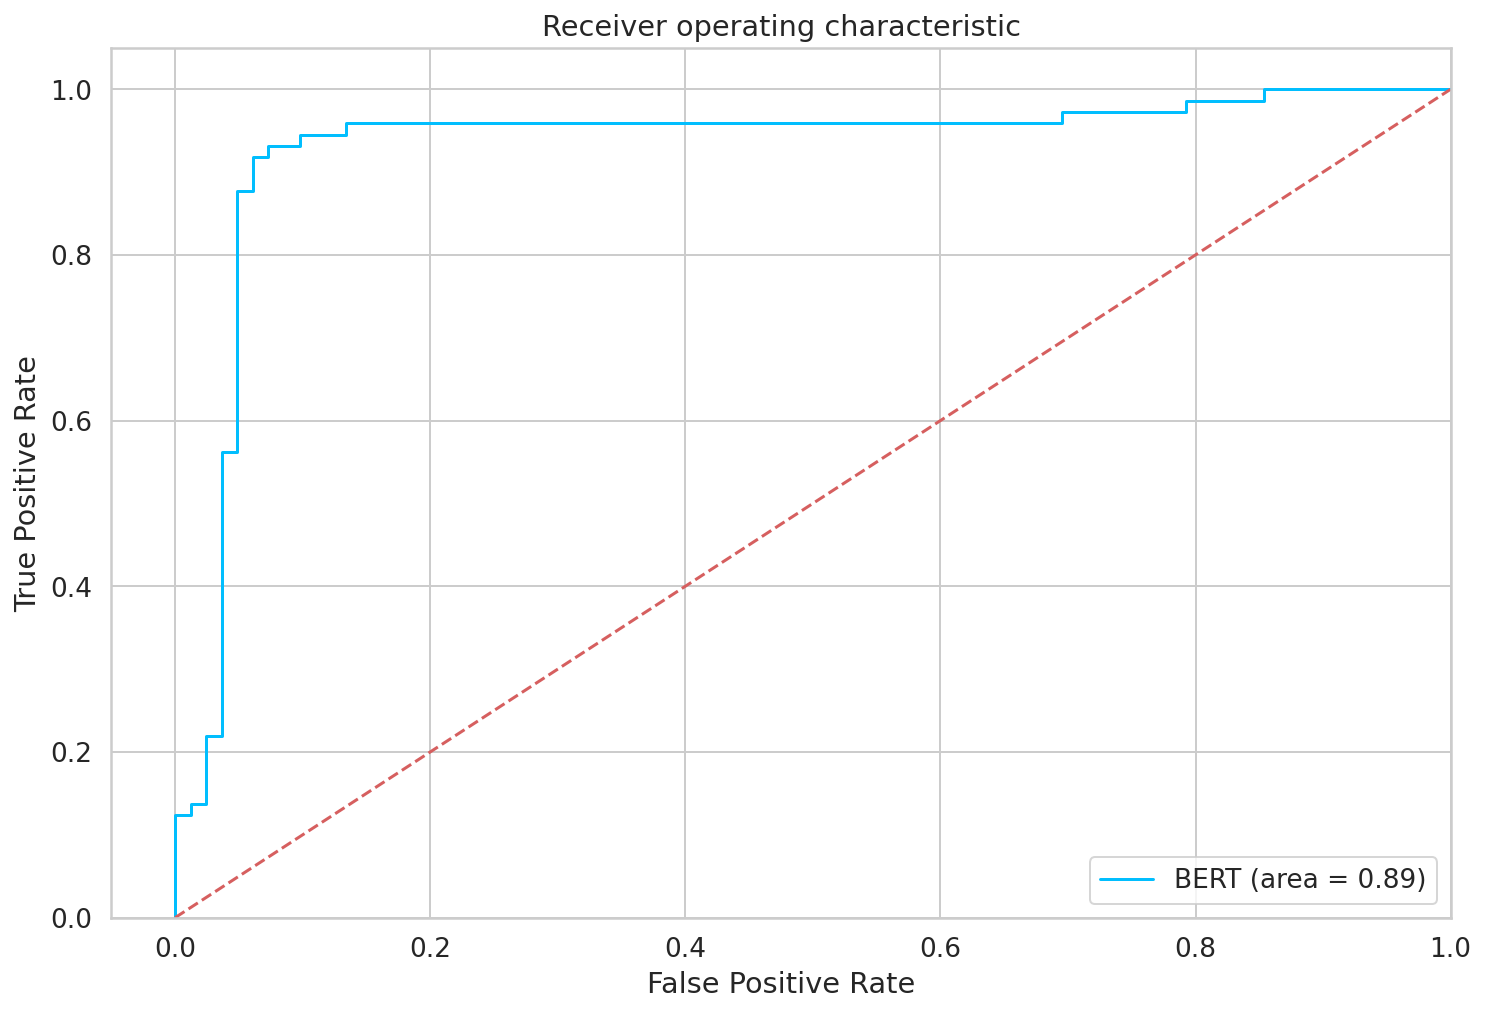

In [30]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_'+ current_time +'.png')
# plt.savefig(foldername + '/Log_ROC_'+ current_time +'.png'')
plt.show()

In [31]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,Are the vogmasks comfortable? I live in Sydney...,1,0,0.000066,"[0.9999336, 6.6348795e-05]"
1,"RT _larios: When the fuck did it get so late, ...",1,1,0.998330,"[0.0016696166, 0.9983304]"
2,"RT : Roll me like a blunt, because 2020 is her...",1,1,0.999894,"[0.000105718704, 0.99989426]"
3,RT : drunk af,1,1,0.999681,"[0.00031878572, 0.99968123]"
4,n e way i’m still kinda drunk but it’s six am ...,1,1,0.999076,"[0.0009243939, 0.99907553]"
...,...,...,...,...,...
150,feeling a lil weird ab my kacey ticket after t...,0,0,0.000063,"[0.99993694, 6.305212e-05]"
151,"yeah *ppfffs* i wont change either, the only t...",0,1,0.965702,"[0.034297835, 0.96570224]"
152,RT : My cat of 9 years has gone missing. Knowi...,0,0,0.000321,"[0.99967873, 0.00032131522]"
153,_oyugi _Aketch Betty having an obligation and ...,0,0,0.014695,"[0.985305, 0.014695002]"


In [32]:
dff.to_csv('test_result/'+ current_time + 'testtresult.csv')
current_time

'2023_02_10-01_37PM'

In [33]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.96      0.82      0.88        82
           N       0.82      0.96      0.89        73

    accuracy                           0.88       155
   macro avg       0.89      0.89      0.88       155
weighted avg       0.89      0.88      0.88       155



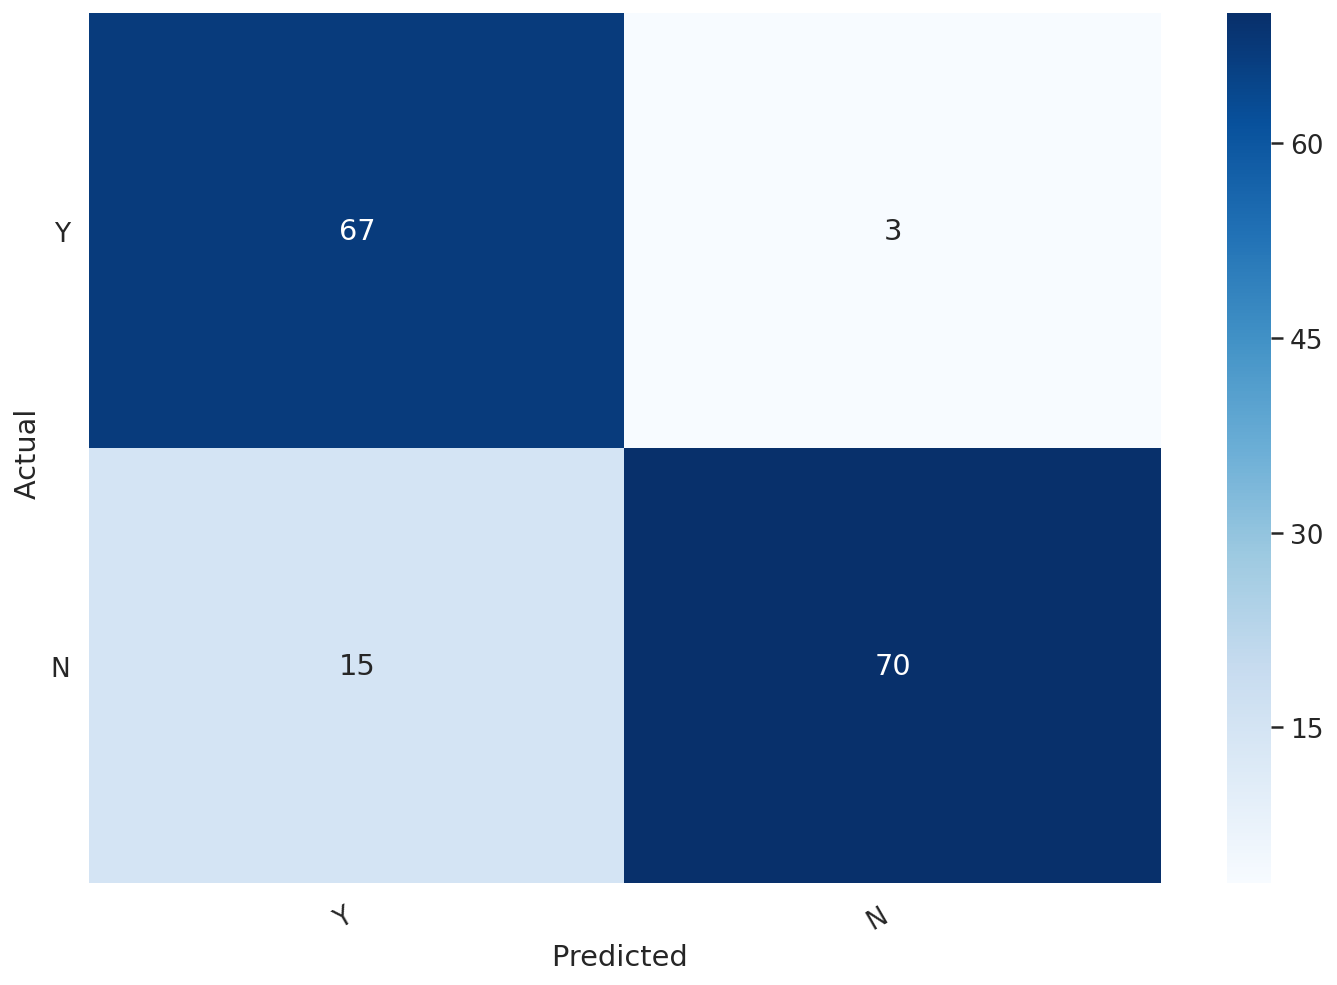

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual ')
  plt.xlabel('Predicted ')
  plt.savefig('confusion_matrix/'+ 'cm_'+current_time + '.png')


cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

# PREDICTION ON REAL DATA

In [43]:
# df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_01.csv',lineterminator='\n',   skipinitialspace=True)
# df_pred.drop(df_pred.columns[[0, 1,2, 4]], axis=1, inplace=True)
# df_pred = df_pred.rename(columns={df_pred.columns[0]: 'Tweet'})
# df_pred['label']= 1

In [47]:
# df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2022_11.csv',lineterminator='\n',skipinitialspace=True)
df_pred = pd.read_fwf('/users/kent/jmaharja/drugAbuse/input/2022_11.csv')
df_pred['label']= 1
# df_pred = df_pred[:100]

In [48]:
df_pred.shape

(26726, 2)

In [49]:
# from sklearn.utils import shuffle
# df_pred = shuffle(df_pred)

In [50]:
# df_pred = df_pred[:150000]
# df_pred = df_pred[150000:160000]
# df_pred = df_pred[160000:170000]
# df_pred = df_pred[170000:180000]
# df_pred = df_pred[180000:190000]
# df_pred = df_pred[190000:200000]
# df_pred = df_pred[230000:240000]
df_pred = df_pred[:1000]

In [51]:
pred_data_loader = create_data_loader(df_pred, tokenizer, MAX_LEN, BATCH_SIZE)

In [52]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, pred_data_loader)

In [53]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,tweet,Real,Predicted,Pred-prob,All Pred-probs
0,I *think* they aren't actually trying to crack...,1,0,0.000156,"[0.9998441, 0.00015589761]"
1,You can't have people across the red line but ...,1,0,0.000034,"[0.999966, 3.4009732e-05]"
2,FOH,1,0,0.000035,"[0.9999654, 3.4573335e-05]"
3,Reading the nationwide reports of the rampant ...,1,0,0.000037,"[0.99996316, 3.687904e-05]"
4,Watching the latest greys anatomy LSD!?!?!?!!!...,1,0,0.000038,"[0.99996173, 3.8224516e-05]"
...,...,...,...,...,...
995,thanks,1,0,0.000034,"[0.9999659, 3.4087338e-05]"
996,You reckon ole Peggy’s ever tripped over those...,1,0,0.000044,"[0.99995553, 4.4427503e-05]"
997,Was reading an article about prostitution in C...,1,0,0.000041,"[0.9999585, 4.1447893e-05]"
998,It does make me wanna workout and sell cocaine...,1,1,0.999908,"[9.209157e-05, 0.99990785]"


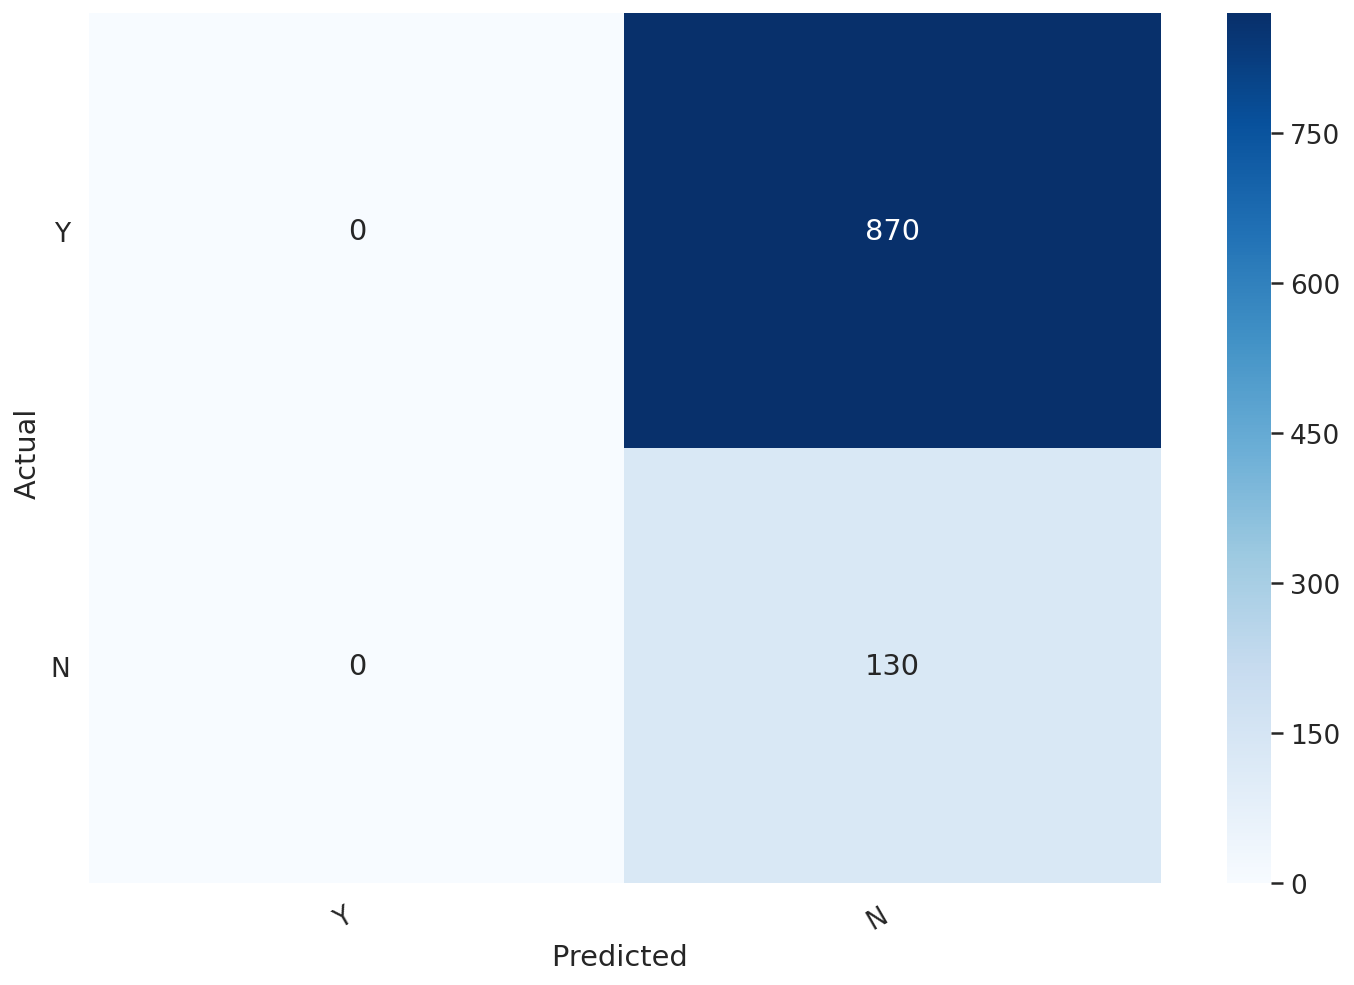

In [54]:
cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

In [44]:
# dff.to_csv('test_result/'+ current_time + 'prediction_result.csv')

In [55]:
dff[dff['Predicted']==1]

,tweet,Real,Predicted,Pred-prob,All Pred-probs
8,"um , is it crack yall smoke ? is it ?",1,1,0.999801,"[0.00019952642, 0.9998005]"
9,"maybe it’s me , maybe im the one smoking crack",1,1,0.999854,"[0.00014578317, 0.9998542]"
10,You crack me up. Nancy Reagen 🤣,1,1,0.992436,"[0.007563964, 0.992436]"
14,"Do they eat them whole, or go crack them open ...",1,1,0.981340,"[0.018660104, 0.9813399]"
21,head feels really hot tired af\n\ncan hear a b...,1,1,0.999920,"[7.9801815e-05, 0.99992025]"
...,...,...,...,...,...
975,Stop smoking 🚬 the crack stupid. y'all are los...,1,1,0.999906,"[9.382702e-05, 0.9999062]"
976,If you think I’m giving my 5 yr old a phone yo...,1,1,0.999819,"[0.00018089813, 0.9998191]"
991,unsung documentaries: she got signed she becam...,1,1,0.999920,"[7.9972e-05, 0.99992]"
998,It does make me wanna workout and sell cocaine...,1,1,0.999908,"[9.209157e-05, 0.99990785]"


In [46]:
dff[dff['Predicted']==0]

,tweet,Real,Predicted,Pred-prob,All Pred-probs
0,I *think* they aren't actually trying to crack...,1,0,0.000156,"[0.9998441, 0.00015589761]"
1,You can't have people across the red line but ...,1,0,0.000034,"[0.999966, 3.4009732e-05]"
2,FOH,1,0,0.000035,"[0.9999654, 3.4573335e-05]"
3,Reading the nationwide reports of the rampant ...,1,0,0.000037,"[0.99996316, 3.687904e-05]"
4,Watching the latest greys anatomy LSD!?!?!?!!!...,1,0,0.000038,"[0.99996173, 3.8224516e-05]"
...,...,...,...,...,...
9993,"Rita tied 7-7, Loyola up 14-3 in early CCL pla...",1,0,0.000054,"[0.999946, 5.400212e-05]"
9995,Agreed on the concussion. While I certainly do...,1,0,0.000034,"[0.99996567, 3.436779e-05]"
9996,LeonardCohen,1,0,0.000035,"[0.9999647, 3.523783e-05]"
9997,Thanks for #LeonardCohen His voice and lyrics ...,1,0,0.000045,"[0.9999547, 4.524681e-05]"


In [56]:
ones = dff[dff['Predicted']==1]['tweet']
ones.to_csv('test_result/'+ current_time+'_ones.csv')

In [47]:
# zeros = dff[dff['Predicted']==0]['tweet']
# zeros.to_csv('test_result/2023_neg.csv')

In [120]:
current_time

'2023_01_31-09_25AM'

# POST REVIEW

In [52]:
# ones.tweet.tolist()

# ' '.join(ones['tweet'].tolist())
# ones.tweet.str.cat(sep=', ')